In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import numpy as np
import sklearn
import torch
import torchaudio
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler


In [4]:
gauth = GoogleAuth()           
drive = GoogleDrive(gauth)  
# read false samples
false_dict = {'name':[], 'id':[]}
file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format('13yBGR5nWOgp_U-cbYSi5XZZ0Sr1JxQlj')}).GetList()
for file in file_list:

    false_dict['name'].append(file['title'])
    false_dict['id'].append(file['id'])
    
# read true samples
true_dict = {'name':[], 'id':[]}
file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format('1mUhbkiEhDEAZgfpoO85k9yNwnGDdmLR4')}).GetList()
for file in file_list:

    true_dict['name'].append(file['title'])
    true_dict['id'].append(file['id'])

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=720490533888-nr5f4brm1bg2n064me0vba96d921uqnt.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [5]:
df1 = pd.DataFrame(false_dict)
df1['label'] = 0

df2 = pd.DataFrame(true_dict)
df2['label'] = 1

# combine both dataframes
df = pd.concat([df1,df2])
df = df.sample(frac=1, random_state=100).reset_index(drop=True)

print('The length of the dataset is: ', f'{df.shape[0]:,}')

df.head(5)

The length of the dataset is:  1,375


,name,id,label
0,Maninoise702.wav,1FWpCsKibDbId0SqLCmzKFj_tONbMYmpf,1
1,Mani_false262.wav,1rVyQFTt2vB45wkGh6CBore51zcJymcRF,0
2,Mani_false301.wav,15KO3OYrncTg00loPxIru25A6kNE5d096,0
3,Mani_false364.wav,1HQkXzMZf-xY7IHpz-swgUhiMMAxD46_P,0
4,Maninoise634.wav,10ELZmK-K1hXdRL7AW8_VFzBM7ft3N2-2,1


In [6]:
#Split the dataset into train and test dataset
trainset, testset = train_test_split(df, test_size=0.30, random_state=100)

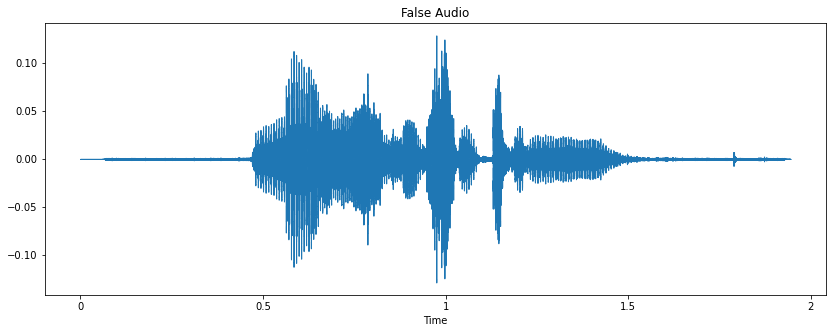

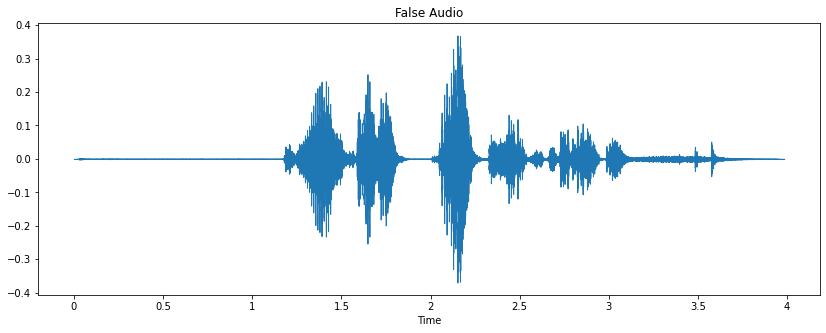

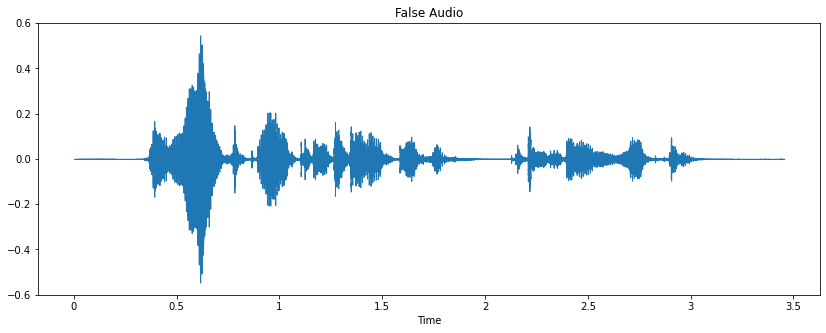

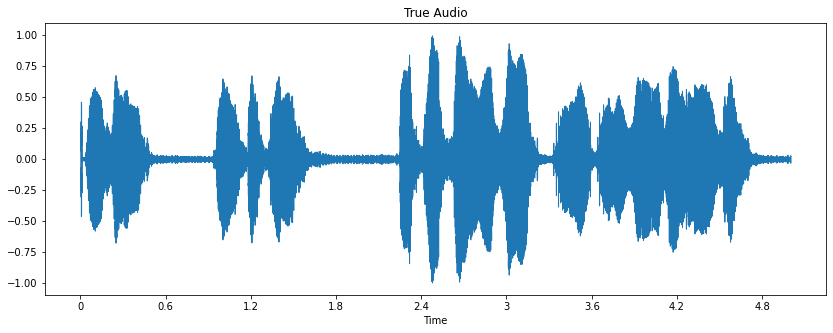

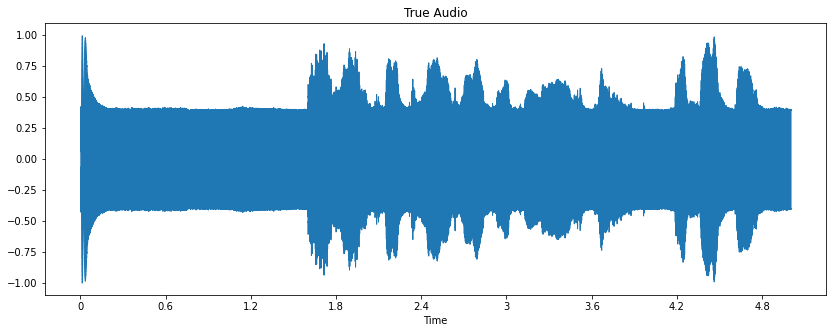

In [7]:
# View the audio files
n = 5
for i in range(n):
    read_file = drive.CreateFile({'id': trainset.iloc[i][1]})
    read_file.GetContentFile(trainset.iloc[i][0])
 
    x , sr = librosa.load(trainset.iloc[i][0])
 
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
        
    plt.title(name)
   

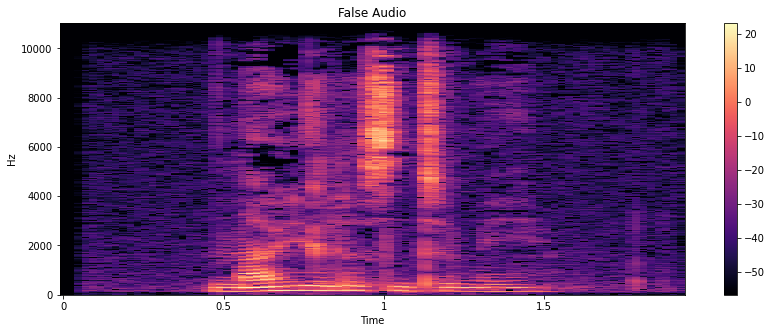

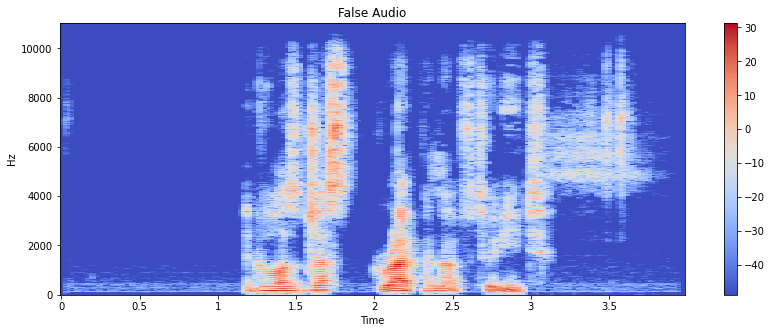

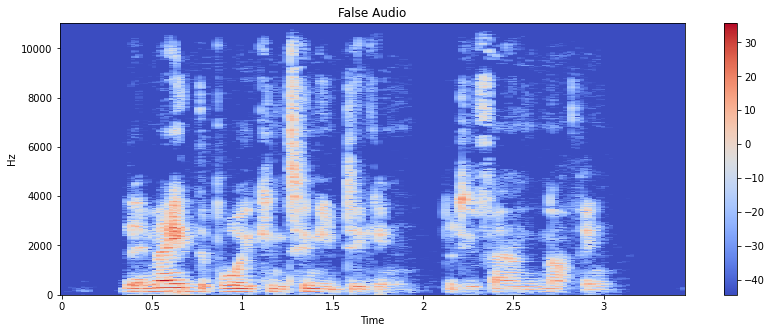

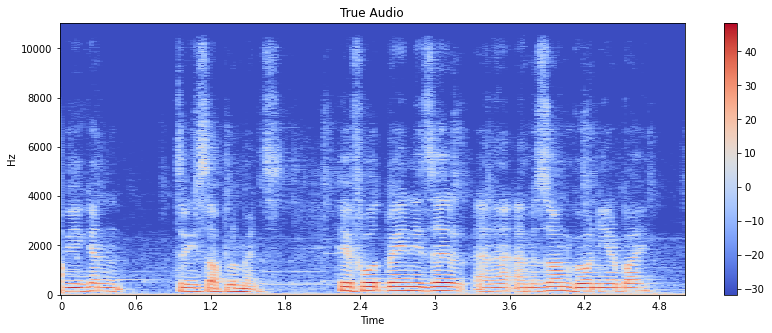

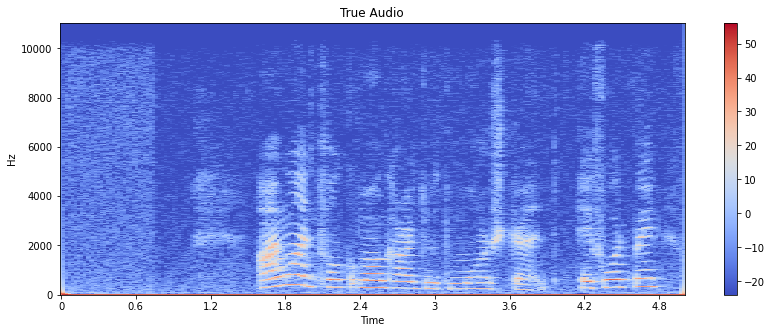

In [8]:
#Spectogram
n = 5
for i in range(n):
    read_file = drive.CreateFile({'id': trainset.iloc[i][1]})
    read_file.GetContentFile(trainset.iloc[i][0])
    
    x , sr = librosa.load(trainset.iloc[i][0])
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
    plt.title(name)
    plt.colorbar()

/var/folders/xh/5cg8lrrd71530j0krmqch2l80000gn/T/ipykernel_13372/3815334768.py:12: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.9653145e-07
  5.3826618e-08  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
/var/folders/xh/5cg8lrrd71530j0krmqch2l80000gn/T/ipykernel_13372/3815334768.py:12: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
/var/folders/xh/5cg8lrrd71530j0krmqch2l80000gn/T/ipykernel_13372/3815334768.py:12: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
/var/folders/xh/5cg8lrrd71530j0krmqch2l

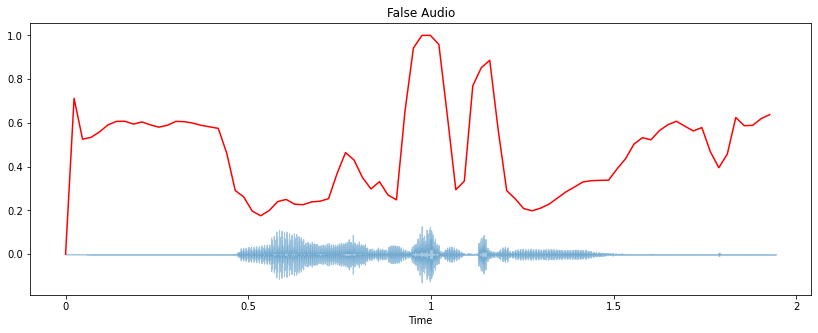

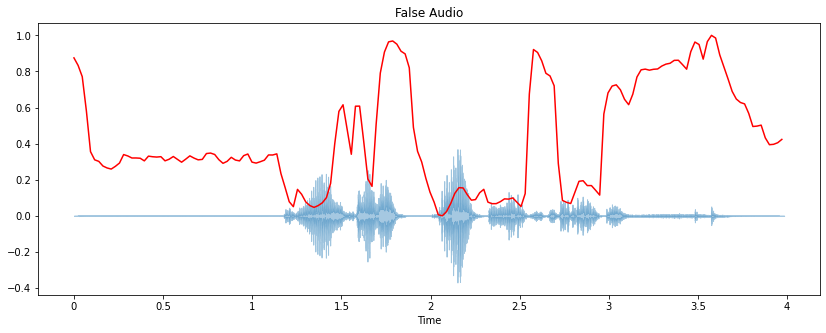

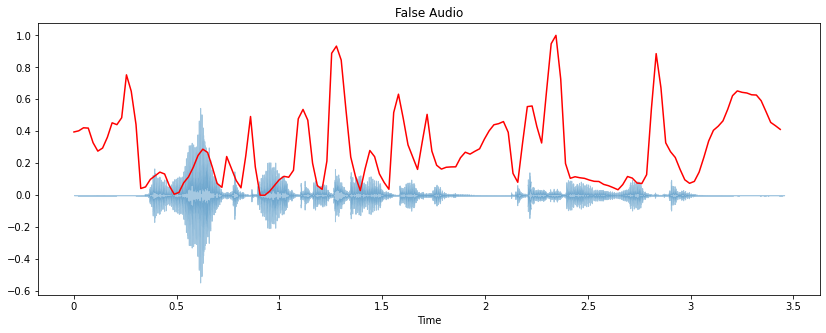

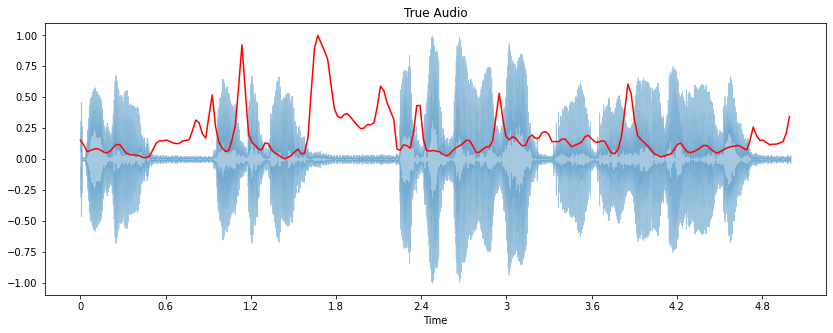

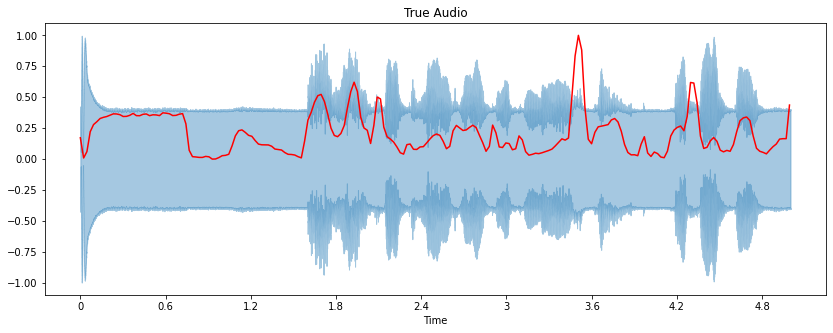

In [9]:
#spectral centroid

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

n = 5
for i in range(n):
    read_file = drive.CreateFile({'id': trainset.iloc[i][1]})
    read_file.GetContentFile(trainset.iloc[i][0])
    
    x , sr = librosa.load(trainset.iloc[i][0])
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    # Normalising the spectral centroid for visualisation
    plt.figure(figsize=(14, 5))
    #Plotting the Spectral Centroid along the waveform
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
    plt.title(name)

In [10]:
def features(df):
    
   
    feature_dict = {'rmse':[],'chroma_stft':[], 'spec_cent':[],'spec_bw':[],'rolloff':[],'zcr':[],'mfcc':[], 'label':[], 
                'rmse_min':[],'chroma_stft_min':[], 'spec_cent_min':[],'spec_bw_min':[],'rolloff_min':[],'zcr_min':[],
                'mfcc_min':[], 'rmse_max':[],'chroma_stft_max':[], 'spec_cent_max':[],'spec_bw_max':[],'rolloff_max':[],'zcr_max':[],
                'mfcc_max':[]}

    for i in tqdm(range(df.shape[0])):
     
        read_file = drive.CreateFile({'id': df.iloc[i][1]})
        read_file.GetContentFile(df.iloc[i][0])
        
        x , sr = librosa.load(df.iloc[i][0])
        rmse = librosa.feature.rms(y=x)
        chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=x, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(x)
        mfcc = librosa.feature.mfcc(y=x, sr=sr)
        
        target = df.iloc[i]['label']
       
        # mean
     
        feature_dict['rmse'].append(np.mean(rmse))
        feature_dict['chroma_stft'].append(np.mean(chroma_stft))
        feature_dict['spec_cent'].append(np.mean(spec_cent))
        feature_dict['spec_bw'].append(np.mean(spec_bw))
        feature_dict['rolloff'].append(np.mean(rolloff))
        feature_dict['zcr'].append(np.mean(zcr))
        feature_dict['mfcc'].append(np.mean(mfcc))
        feature_dict['label'].append(target)
 
        # min
        feature_dict['rmse_min'].append(np.min(rmse))
        feature_dict['chroma_stft_min'].append(np.min(chroma_stft))
        feature_dict['spec_cent_min'].append(np.min(spec_cent))
        feature_dict['spec_bw_min'].append(np.min(spec_bw))
        feature_dict['rolloff_min'].append(np.min(rolloff))
        feature_dict['zcr_min'].append(np.min(zcr))
        feature_dict['mfcc_min'].append(np.min(mfcc))
   
        # max
        feature_dict['rmse_max'].append(np.max(rmse))
        feature_dict['chroma_stft_max'].append(np.max(chroma_stft))
        feature_dict['spec_cent_max'].append(np.max(spec_cent))
        feature_dict['spec_bw_max'].append(np.max(spec_bw))
        feature_dict['rolloff_max'].append(np.max(rolloff))
        feature_dict['zcr_max'].append(np.max(zcr))
        feature_dict['mfcc_max'].append(np.max(mfcc))
        
        
        
    return feature_dict



In [11]:
#Extract features (train data)
temp = features(trainset)
df_train = pd.DataFrame(temp)
df_train.head



  0%|          | 0/962 [00:00<?, ?it/s]

/opt/anaconda3/envs/mle-course/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


<bound method NDFrame.head of          rmse  chroma_stft    spec_cent      spec_bw      rolloff       zcr  \
0    0.009660     0.434092  3079.955283  2705.643967  6282.183838  0.174863   
1    0.015264     0.423685  3113.393895  2158.265176  5379.419797  0.205927   
2    0.021403     0.426174  2276.890152  2034.377790  4241.968757  0.138927   
3    0.157818     0.298526  1105.487322  1527.591691  2181.532796  0.037916   
4    0.403637     0.570740   821.505815  1791.136631  1540.471395  0.001817   
..        ...          ...          ...          ...          ...       ...   
957  0.279680     0.639749  2884.549415  2342.975721  5859.822591  0.033538   
958  0.143768     0.684537  3324.379872  2259.211172  6121.819213  0.235488   
959  0.161028     0.493841  3230.974929  2239.455894  6033.786423  0.240932   
960  0.002763     0.476004  3185.544092  2366.535642  5884.450195  0.218197   
961  0.184773     0.421893   753.023576  1309.112723  1524.072266  0.015410   

          mfcc  label

In [12]:
#Extract features (test data)

temp = features(testset)

df_test = pd.DataFrame(temp)
df_test.head

  0%|          | 0/413 [00:00<?, ?it/s]

/opt/anaconda3/envs/mle-course/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


<bound method NDFrame.head of          rmse  chroma_stft    spec_cent      spec_bw      rolloff       zcr  \
0    0.134025     0.474065   987.061158  1482.268191  2009.566243  0.023593   
1    0.237629     0.623396   378.083820   876.752341   699.995381  0.006150   
2    0.066193     0.409972  1971.672273  1374.369143  3458.666424  0.154547   
3    0.037699     0.488622  3037.963436  2316.587104  5777.452021  0.271681   
4    0.040929     0.370637  1983.064267  1659.985985  3721.351600  0.130371   
..        ...          ...          ...          ...          ...       ...   
408  0.283149     0.643065  2877.017332  2357.827233  5875.573730  0.025944   
409  0.064161     0.440642  1268.795803  1273.738604  2356.025544  0.082371   
410  0.181705     0.663753  3203.060703  2302.795268  6063.609129  0.138845   
411  0.209891     0.369052   750.677977  1441.751408  1351.507568  0.016296   
412  0.056390     0.385702  2159.120413  1838.969749  3977.523099  0.141036   

          mfcc  label

In [18]:
#seperate target from features
X_train = df_train.loc[:, df_train.columns != 'label']
y_train = df_train['label']

X_test = df_test.loc[:, df_test.columns != 'label']
y_test = df_test['label']


In [19]:
#Scale the x values
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [35]:
#A Neural network model and train

mlp = MLPClassifier(activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

MLPClassifier(max_iter=500)

In [36]:
# Predict
y_pred = mlp.predict(X_test)

print('The prediction accuracy is: ', round(accuracy_score(y_test, y_pred),2)*100)

The prediction accuracy is:  99.0


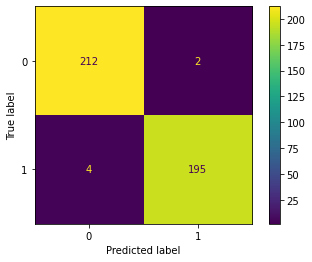

In [37]:
#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)
plt.show()